## water mass properties along 1000m isobath, cdw isopycnals, ekman pumping*rho_area. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43621,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:46007,Total threads: 4
Dashboard: /proxy/37505/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:35481,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

#look at years 6-10
start_time='2155-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
lat_range = slice(-90,-59)

isobath_depth = 1000

In [5]:
yt_ocean = cc.querying.getvar(control,'yt_ocean',master_session,n=1)
print(yt_ocean[600])
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(control,'xt_ocean',master_session,n=1)
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
area_t = cc.querying.getvar(control,'area_t',master_session,n=1)

<xarray.DataArray 'yt_ocean' ()>
array(-54.02315489)
Coordinates:
    yt_ocean  float64 -54.02
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y
    ncfiles:         ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9...
    contact:         Andy Hogg
    email:           andy.hogg@anu.edu.au
    created:         2020-06-11
    description:     0.1 degree ACCESS-OM2 global model configuration under t...
    notes:           Additional daily outputs saved from 1 Jan 1950 to 31 Dec...


In [6]:
iso = xr.open_dataset('/home/561/jn8053/g_e14/misc/Antarctic_isobath_1000m.nc')
iso.x

<xarray.DataArray 'x' (dim_0: 6002)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Dimensions without coordinates: dim_0

In [7]:
lat_along_contour=iso.y
lon_along_contour=iso.x
num_points=iso.x.shape[0]

In [8]:
# load density control:
rho = cc.querying.getvar(control, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute() #.resample({'time':'Y'}).mean('time')

lon_range  = slice(-115,-110) #-50.04-
rho1_c=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_c=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

In [9]:
# load density up:
rho = cc.querying.getvar(easterlies_up, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute()

lon_range  = slice(-115,-110) #-50.04-
rho1_up=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_up=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

In [10]:
# load density down:
rho = cc.querying.getvar(easterlies_down, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute() 

lon_range  = slice(-115,-110) #-50.04-
rho1_down=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_down=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

In [11]:
ht_wpartials_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/depth_iso1000m.npy');

In [12]:
def gcdist(lat1, lat2, lon1, lon2):
    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [13]:
#calculate distance along contour in km
print(iso.x.shape,iso.y.shape) #lon_bin_midpoints.shape,lat_bin_midpoints.shape)
cdist=np.zeros(iso.x.shape) #lon_bin_midpoints.shape)

for i in range(1,iso.x.shape[0]): #lon_bin_midpoints.shape[0]):
    #cdist[i]=cdist[i-1]+gcdist(lat_bin_midpoints[i-1],lat_bin_midpoints[i],lon_bin_midpoints[i-1],lon_bin_midpoints[i])
    cdist[i]=cdist[i-1]+gcdist(iso.y[i-1],iso.y[i],iso.x[i-1],iso.x[i])  

(6002,) (6002,)


In [23]:
xticks=np.zeros(7)
xticklabels=[-250, -200,-150, -100,-50, 0, 50]

for i in range(0,xticks.shape[0]):
    tmp=(np.abs(iso.x.data - xticklabels[i])).argmin()
    xticks[i]=tmp

print(xticks)
cdist[xticks.astype(int)]
#difference_array = np.absolute(arr-x)

[ 474. 1298. 2192. 2848. 4114. 4794. 5567.]


array([ 1739.84558383,  4768.26511642,  7397.94857504,  9332.58396655,
       13973.49526387, 16136.70293094, 19140.36414759])

In [15]:
temp_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_control.npy')
rho_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_control.npy')
salt_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/salt_iso1000m_control.npy')

In [16]:
ekman_con_tx0_aint=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks//Ekman_pumping/ekman_con_tx0_aint.npy')
ekman_up_tx0_aint=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks//Ekman_pumping/ekman_up_tx0_aint.npy')
ekman_down_tx0_aint=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks//Ekman_pumping/ekman_down_tx0_aint.npy')

In [17]:
ekman_con=xr.open_dataset('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks//Ekman_pumping/ekmanpump_control_sigma02155-2159.nc').mean(dim='year')

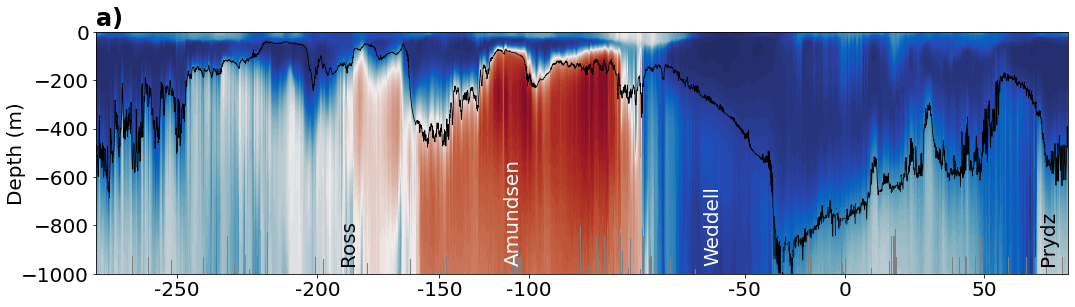

In [24]:
fig = plt.figure(figsize=(15, 12))

fontsize=20
plt.rcParams['font.size'] = fontsize

ax0 = fig.add_axes([0,0.75,0.9,0.28])
ax = ax0
ax.patch.set_color('.5')
ax.set_title('a)', loc='left', fontweight='bold')
ax.set_ylim(-1000,0)
norm = col.Normalize(vmin=-2,vmax=2)
levels=np.arange(-2,2.05,.05)
ticks = [-2,-1,0,1,2]
pc = ax.contourf(cdist,-st_ocean,temp_contour-273.13,
                   cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
pr=ax.contour(cdist,-st_ocean,rho_contour-1000,levels=[27.75],colors='k',linewidths=.8)
plt.tick_params(labelsize=fontsize)
ax.set_xticks(cdist[xticks.astype(int)])
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Depth (m)',fontsize=fontsize,labelpad=-5)

plt.text(.42, .05, 'Amundsen', color='w', size = fontsize,rotation=90,transform=ax.transAxes)
plt.text(.625, .05, 'Weddell', color='w', size = fontsize,rotation=90,transform=ax.transAxes)
plt.text(.25, .05, 'Ross', color='k', size = fontsize,rotation=90,transform=ax.transAxes)
plt.text(.97, .05, 'Prydz', color='k', size = fontsize,rotation=90,transform=ax.transAxes)

'''# colorbar:
cax = fig.add_axes([0.915,0.75,0.022,0.28])
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'max',ticks=ticks)
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

ax1 = fig.add_axes([0,0.425,0.9,0.28])
ax = ax1
ax.patch.set_color('.5')
ax.set_title('b)', loc='left', fontweight='bold')
ax.set_ylim(-1000,0)
norm = col.Normalize(vmin=34.2,vmax=34.8)
levels=np.arange(34.2,34.81,.01)
ticks = [34.2,34.4,34.6,34.8]


norm = col.Normalize(vmin=34.27,vmax=34.77)
levels=np.arange(34.27,34.78,.01)
ticks = [34.3,34.4,34.5,34.6,34.7]

pc = ax.contourf(cdist,-st_ocean,salt_contour,
                   cmap = cmocean.haline, norm = norm,levels=levels,extend='both')
pr=ax.contour(cdist,-st_ocean,rho_contour-1000,levels=[27.75],colors='k',linewidths=0.8)
plt.tick_params(labelsize=fontsize)
ax.set_xticks(cdist[xticks.astype(int)])
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Longitude ($^\circ$)',fontsize=fontsize,labelpad=-1)
ax.set_ylabel('Depth (m)',fontsize=fontsize,labelpad=-5)

# colorbar:
cax = fig.add_axes([0.915,0.425,0.022,0.28])
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both',ticks=ticks)
cbar.set_label(r'Salinity',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

ax2 = fig.add_axes([0,-.01,0.45,0.36])
ax = ax2
ax.set_title('c)', loc='left', fontweight='bold')
ax.patch.set_color('.6')
#ax.set_title('CONTROL',fontsize=fontsize)

ax.set_xlim(75,69)
ax.set_ylim(-1300,0)

norm = col.Normalize(vmin=27.5,vmax=27.9)
levels=np.arange(27.5,27.905,.005)
ticks = [27.5,27.7,27.9]
p1 = ax.contourf(-rho1_c.yt_ocean,-rho1_c.st_ocean,rho1_c,
                   cmap = plt.cm.BuPu, norm = norm,levels=levels,extend='both')

p2=ax.contour(-rho1_c.yt_ocean,-rho1_c.st_ocean,rho1_c,levels=[27.75],colors='k',label='CONTROL',linewidths=2)
p3=ax.contour(-rho1_up.yt_ocean,-rho1_up.st_ocean,rho1_up,levels=[27.75],colors='C0',label='WIND+',linewidths=2)
p4=ax.contour(-rho1_down.yt_ocean,-rho1_down.st_ocean,rho1_down,levels=[27.75],colors='C1',label='WIND$-$',linewidths=2)

#plt.tick_params(labelsize=fontsize)
ax.set_ylabel('Depth (m)',fontsize=fontsize,labelpad=-5)
ax.set_xlabel('Latitude ($^\circ$S)',fontsize=fontsize)

h2,_ = p2.legend_elements()
h3,_ = p3.legend_elements()
h4,_ = p4.legend_elements()
ax.legend([h2[0], h3[0], h4[0]], ['CONTROL', 'WIND+','WIND$-$'],fontsize=fontsize, loc="lower right")

# colorbar:
cax = fig.add_axes([0.015,0.05,0.24,0.03])
cbar = plt.colorbar(p1, cax=cax,orientation = 'horizontal',extend = 'both',ticks=ticks)
cbar.set_label(r'Density (kg/m$^3$)',fontsize=fontsize,labelpad=1)
cbar.ax.tick_params(labelsize=fontsize)

ax4 = fig.add_axes([0.55,-.01,0.46,0.36])
ax=ax4

ax.set_title('d)', loc='left', fontweight='bold')
ax.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint/1E10,linestyle='-',color='k',label='CONTROL',linewidth=2)
ax.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint/1E10,linestyle='-',color='C0',label='WIND+',linewidth=2)
ax.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint/1E10,linestyle='-',color='C1',label='WIND$-$',linewidth=2)
ax.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)

ax.set_xlim((26.5,28.25))
ax.set_ylim((-5,8))
ax.set_ylabel(r'Ekman pumping (x10$^{10}$ m$^3$/day)')
ax.set_xlabel('Surface isopycnal (kg/m$^3$)')
ax.set_xticks([26.5,26.8,27.1,27.4,27.7,28])
ax.legend(fontsize=fontsize, loc="upper right")'''

plt.tight_layout()

fig_path = '/g/data/v45/akm157/figures/easterlies/paper_figures/'
plt.savefig(fig_path + 'Figure5.png',bbox_inches = 'tight',dpi=250)

(6002,)


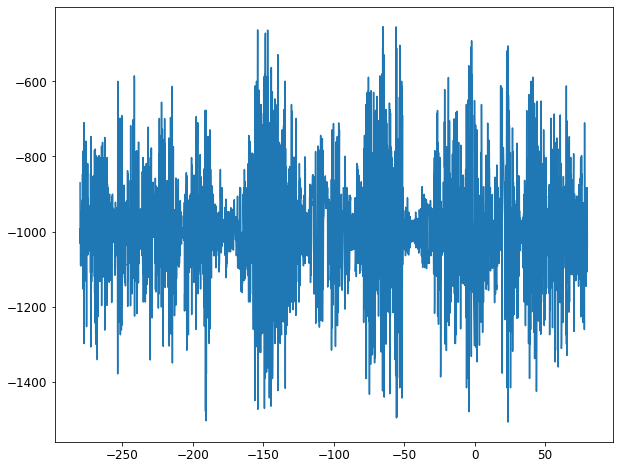

In [40]:
ht_wpartials=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/depth_iso1000m.npy');
print(ht_wpartials.shape)
#plot as distance along contour

plt.figure(figsize=(10,8))
plt.plot(iso.x,-ht_wpartials)

In [41]:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
#contour_file
for k in contour_file.iterkeys():
    print(k)

contour_mask_numbered
contour_masked_above
contour_depth
xt_ocean
yt_ocean
mask_y_transport
mask_x_transport
mask_y_transport_numbered
mask_x_transport_numbered


In [46]:
contour_file['xt_ocean']

array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])

In [45]:
salt_contour_control=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/salt_iso1000m_control.npy')
temp_contour_control=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_control.npy')
rho_contour_control=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_control.npy')
print(salt_contour_control.shape,temp_contour_control.shape,rho_contour_control.shape)

(75, 6002) (75, 6002) (75, 6002)


In [22]:
iso

<xarray.Dataset>
Dimensions:  (dim_0: 6002)
Dimensions without coordinates: dim_0
Data variables:
    x        (dim_0) float64 -279.9 -279.8 -279.7 -279.7 ... 79.75 79.85 79.95
    y        (dim_0) float64 -66.01 -65.99 -65.99 ... -66.07 -66.06 -66.04

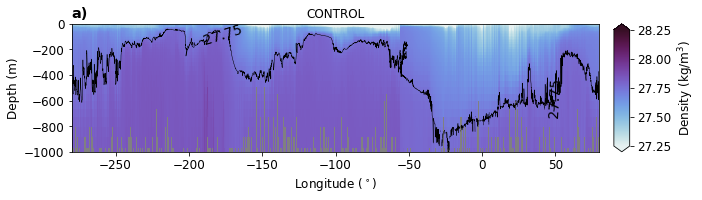

In [23]:
#plot as distance along contour
fontsize=12
plt.rcParams['font.size'] = fontsize

levels=np.arange(27.5, 28.5, 0.25)
levels2=np.arange(-2, 3, 0.2)
#levels=np.arange(27.5, 28., 0.05)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
ax = plt.gca()
ax.set_title('a)', loc='left', fontweight='bold')
plt.gca().patch.set_color('.5')
plt.title('CONTROL',fontsize=fontsize)
plt.ylim(-1000,0)
#plt.xlim(-140,-100)
pc=plt.pcolormesh(iso.x,-st_ocean,rho_contour_control-1000,cmap=cmocean.dense,vmin=27.25,vmax=28.25)
pr=plt.contour(iso.x,-st_ocean,rho_contour-1000,levels=[27.75],colors='k',linewidths=0.5)
#pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Density (kg/m$^3$)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=12)

In [47]:
#deal with partial thickness bottom cells
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean},axis=[1,2])

# import bathymetry:
ht = cc.querying.getvar('01deg_jra55v13_ryf9091','ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_range)

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [48]:
st_ocean_wpartials=thickness.sum('st_ocean')
st_ocean_wpartials

<xarray.DataArray 'st_edges_ocean' (yt_ocean: 510, xt_ocean: 3600)>
dask.array<sum-aggregate, shape=(510, 3600), dtype=float64, chunksize=(510, 900), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>

In [115]:
st_edges_array

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 76, yt_ocean: 510, xt_ocean: 3600)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.08256153e+00, 1.08256153e+00, 1.08256153e+00, ...,
         1.08256153e+00, 1.08256153e+00, 1.08256153e+00],
        [1.08256153e+00, 1.08256153e+00, 1.08256153e+00, ...,
         1.08256153e+00, 1.08256153e+00, 1.08256153e+00],
        [1.08256153e+00, 1.08256153e+00, 1.08256153e+00, ...,
         1.08256153e+00, 1.08256153e+00, 1.08256153e+00],
...
        [5.61022887e+03, 5.61022887e+03, 5.61022887e+03, ...,
         5.61022887e+03, 5.61022887e+03, 5.61022887e+03],
        [5.61022887e+03, 5.61022887e+03, 5.61022887e+03, ...,
         5.61022887e+03, 5.61022887e+03, 5.61022887e+03],
        [5.61022887e+03, 5.61022887e+03, 5.61022887e+03, ...,
         5.61022887e+03, 5.61022887e+03, 5.61022887e+03]],

       [[5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03],
        [5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03],
        [5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03],
        ...,
        [5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03],
        [5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03],
        [5.80865696e+03, 5.80865696e+03, 5.80865696e+03, ...,
         5.80865696e+03, 5.80865696e+03, 5.80865696e+03]]])
Coordinates:
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.08 -59.03
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
Attributes:
    long_name:       tcell zstar depth edges
    units:           meters
    cartesian_axis:  Z
    positive:        down
    ncfiles:         ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9...
    contact:         Andy Hogg
    email:           andy.hogg@anu.edu.au
    created:         2020-06-11
    description:     0.1 degree ACCESS-OM2 global model configuration under t...
    notes:           Additional daily outputs saved from 1 Jan 1950 to 31 Dec...

In [112]:
depth_contour = np.zeros((num_points))

# depth along contour, loaded indices above:
for count in range(num_points):
    jj = (np.abs(yt_ocean - iso.y[int(count)])).argmin()
    ii = (np.abs(xt_ocean - iso.x[int(count)])).argmin()
    #if count % 500 == 0: #why no partials?
    print(count,jj,ii,yt_ocean[jj].values,xt_ocean[ii].values,st_ocean_wpartials[jj,ii].values,ht[jj,ii].values)
    
    depth_contour[count] = st_ocean_wpartials[jj,ii].values
    
np.save('depth_iso1000m',depth_contour);

0 <xarray.DataArray ()>
array(357) <xarray.DataArray ()>
array(0) -66.02918216452188 -279.95 870.2166748046875 870.2166748046875
1 <xarray.DataArray ()>
array(358) <xarray.DataArray ()>
array(1) -65.9869428101414 -279.84999999999997 1031.433349609375 1031.433349609375
2 <xarray.DataArray ()>
array(358) <xarray.DataArray ()>
array(2) -65.9869428101414 -279.74999999999994 1021.7333374023438 1021.7333374023438
3 <xarray.DataArray ()>
array(358) <xarray.DataArray ()>
array(2) -65.9869428101414 -279.74999999999994 1021.7333374023438 1021.7333374023438
4 <xarray.DataArray ()>
array(359) <xarray.DataArray ()>
array(3) -65.94470345576092 -279.6499999999999 991.5833129882812 991.5833129882812
5 <xarray.DataArray ()>
array(359) <xarray.DataArray ()>
array(3) -65.94470345576092 -279.6499999999999 991.5833129882812 991.5833129882812
6 <xarray.DataArray ()>
array(360) <xarray.DataArray ()>
array(4) -65.90246410138043 -279.5499999999999 1090.8333740234375 1090.8333740234375
7 <xarray.DataArray ()>
a

KeyboardInterrupt: 

In [83]:
count=100
jj=np.abs(yt_ocean - iso.y[int(count)]).argmin()
print(iso.y[count],jj,yt_ocean[jj].values)
ii = (np.abs(xt_ocean - iso.x[int(count)])).argmin()
print(iso.x[count],ii,xt_ocean[ii].values)

print('1000m?',ht[jj,ii].values)

<xarray.DataArray 'y' ()>
array(-66.034282) <xarray.DataArray ()>
array(357) -66.02918216452188
<xarray.DataArray 'x' ()>
array(-272.85) <xarray.DataArray ()>
array(71) -272.8499999999984
1000m? 1013.1666870117188


In [102]:
count=302
jj=np.abs(yt_ocean - iso.y[int(count)])
print(jj.argmin(),yt_ocean[jj.argmin()].values,iso.y[int(count)])

<xarray.DataArray ()>
array(403) -64.06989797544404 <xarray.DataArray 'y' ()>
array(-64.049573)


In [106]:
k=np.abs(depth_contour-1000)
print(k.argmax(),depth_contour[k.argmax()],np.max(np.abs(depth_contour-1000)),)

3382 454.3844909667969 545.6155090332031


In [56]:
def import_temp(exp):
    """
    0: control
    1: UP
    2: DOWN
    """
    if exp == 0:
        temp_tmp = cc.querying.getvar(control, 'temp', master_session, start_time=start_time, end_time=end_time)
        rho_tmp = cc.querying.getvar(control, 'pot_rho_0', master_session, start_time=start_time, end_time=end_time)
    elif exp == 1:
        temp_tmp = cc.querying.getvar(easterlies_up, 'temp', master_session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
        rho_tmp = cc.querying.getvar(easterlies_up, 'pot_rho_0', master_session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
    elif exp == 2:
        temp_tmp = cc.querying.getvar(easterlies_down, 'temp', master_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
        rho_tmp = cc.querying.getvar(easterlies_down, 'pot_rho_0', master_session, frequency='1 monthly', start_time=start_time, end_time=end_time)

    # select latitude range:
    temp_tmp = temp_tmp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
    rho_tmp = rho_tmp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

    # Finished
    return temp_tmp,rho_tmp

In [57]:
(temp,rho) = import_temp(2)
temp=temp.mean(dim='time').compute()
rho=rho.mean(dim='time').compute()
rho

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 510, xt_ocean: 3600)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [1027.1754, 1027.182 , 1027.1897, ..., 1027.1655, 1027.1677,
         1027.1713],
        [1027.1742, 1027.1797, 1027.1873, ..., 1027.1667, 1027.1686,
         1027.171 ],
        [1027.1742, 1027.1785, 1027.1852, ..., 1027.1687, 1027.1699,
         1027.1718]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [84]:
ht[jj,ii].values

array(1013.16668701)

## Extract watermass values along isobath contour:

In [58]:
temp_contour = np.zeros((75,num_points))
rho_contour = np.zeros((75,num_points))

# locations for zonal transport, already calculated indices above:
for count in range(num_points):
    jj = (np.abs(yt_ocean - iso.y[int(count)])).argmin()
    ii = (np.abs(xt_ocean - iso.x[int(count)])).argmin()
    if count % 500 == 0:
        print(count,jj,ii,yt_ocean[jj],xt_ocean[ii],iso.y[int(count)].data,iso.x[int(count)].data) #,temp[:,jj,ii].values
    
    temp_contour[:,count] = temp[:,jj,ii].values
    rho_contour[:,count] = rho[:,jj,ii].values
    
np.save('temp_iso1000m_down',temp_contour);
np.save('rho_iso1000m_down',rho_contour);

0 <xarray.DataArray ()>
array(357) <xarray.DataArray ()>
array(0) <xarray.DataArray 'yt_ocean' ()>
array(-66.02918216)
Coordinates:
    yt_ocean  float64 -66.03
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y
    ncfiles:         ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9...
    contact:         Andy Hogg
    email:           andy.hogg@anu.edu.au
    created:         2020-06-11
    description:     0.1 degree ACCESS-OM2 global model configuration under t...
    notes:           Additional daily outputs saved from 1 Jan 1950 to 31 Dec... <xarray.DataArray 'xt_ocean' ()>
array(-279.95)
Coordinates:
    xt_ocean  float64 -279.9
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X
    ncfiles:         ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9...
    contact:         Andy Hogg
    email:           andy.hogg@anu.edu.au
    created:         2020-06-11
    descri

In [52]:
print(jj,ii,count,temp.shape)

<xarray.DataArray ()>
array(357) <xarray.DataArray ()>
array(0) 0 (63, 75, 2700, 3600)
